# Aurora Data
The code in this notebook has been made with the help of a notebook (https://scitools.org.uk/cartopy/docs/latest/gallery/scalar_data/aurora_forecast.html) developed by Cartopy. Code showing the Aurora and the night/day time should be attribute to their work. Other information, such as the Kp Index and the current level of the geomagnetic storm have been added to the plots. For more data products created by the Space Weather Prediction Center, go to https://services.swpc.noaa.gov.

For more information on viewing the Aurora, visit https://www.swpc.noaa.gov/content/tips-viewing-aurora.

In [1]:
from datetime import datetime, timedelta
import json
from urllib.request import urlopen

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

import cartopy
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

import xarray as xr

## Defintions For Aurora Data

In [2]:
def aurora_cmap():
    """Return a colormap with aurora like colors"""
    stops = {'red': [(0.00, 0.1725, 0.1725),
                     (0.50, 0.1725, 0.1725),
                     (1.00, 0.8353, 0.8353)],

             'green': [(0.00, 0.9294, 0.9294),
                       (0.50, 0.9294, 0.9294),
                       (1.00, 0.8235, 0.8235)],

             'blue': [(0.00, 0.3843, 0.3843),
                      (0.50, 0.3843, 0.3843),
                      (1.00, 0.6549, 0.6549)],

             'alpha': [(0.00, 0.0, 0.0),
                       (0.50, 1.0, 1.0),
                       (1.00, 1.0, 1.0)]}

    return LinearSegmentedColormap('aurora', stops)

cmap = aurora_cmap()

In [3]:
def aurora_forecast():
    """
    Get the latest Aurora Forecast from https://www.swpc.noaa.gov.

    Returns
    -------
    img : numpy array
        The pixels of the image in a numpy array.
    img_proj : cartopy CRS
        The rectangular coordinate system of the image.
    img_extent : tuple of floats
        The extent of the image ``(x0, y0, x1, y1)`` referenced in
        the ``img_proj`` coordinate system.
    origin : str
        The origin of the image to be passed through to matplotlib's imshow.
    dt : datetime
        Time of forecast validity.

    """

    # To plot the current forecast instead, uncomment the following line
    url = 'https://services.swpc.noaa.gov/json/ovation_aurora_latest.json'

    # load data (JSON format)
    response = urlopen(url)
    aurora = json.loads(response.read().decode('utf-8'))
    
    # parse timestamp
    dt = datetime.strptime(aurora['Forecast Time'], '%Y-%m-%dT%H:%M:%SZ')
    dt2 = datetime.strptime(aurora['Observation Time'], '%Y-%m-%dT%H:%M:%SZ')
    
    # convert lists of [lon, lat, value] to 2D array of probability values
    aurora_data = np.array(aurora['coordinates'])
    img = np.reshape(aurora_data[:, 2], (181, 360), order='F')

    img_proj = ccrs.PlateCarree()
    img_extent = (0, 359, -90, 90)
    
    return img, img_proj, img_extent, 'lower', dt, dt2

img, crs, extent, origin, dt, dt2 = aurora_forecast()

## Cloud Data

In [4]:
def hour_rounder(t):
    """Return the datetime rounded to the nearest hour"""
    
    return (t.replace(minute=0, hour=t.hour) + timedelta(hours=t.minute//30))

In [5]:
#find a good run of the HRRR to use
Hrrr_hour = hour_rounder(dt) - timedelta(hours=4)
ds = xr.open_dataset(f'http://nomads.ncep.noaa.gov:80/dods/hrrr/hrrr{Hrrr_hour.strftime("%Y%m%d")}/hrrr_sfc.t{Hrrr_hour.strftime("%H")}z')
print(f'The run of the HRRR being used was initialized on {Hrrr_hour.strftime("%B %d, %Y")} at {Hrrr_hour.strftime("%H")} UTC.')


The run of the HRRR being used was initialized on September 16, 2023 at 19 UTC.


/anaconda3/envs/pyEAE/lib/python3.9/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [6]:
#open the HRRR dataset
ds

<xarray.Dataset>
Dimensions:             (time: 19, lev: 7, lat: 1155, lon: 2503)
Coordinates:
  * time                (time) datetime64[ns] 2023-09-16T18:59:59.999997 ... ...
  * lev                 (lev) float64 1e+03 925.0 850.0 700.0 500.0 300.0 250.0
  * lat                 (lat) float64 21.14 21.17 21.2 ... 52.56 52.59 52.61
  * lon                 (lon) float64 -134.1 -134.1 -134.0 ... -60.97 -60.94
Data variables: (12/150)
    dptprs              (time, lev, lat, lon) float32 ...
    no4lftx180_0mb      (time, lat, lon) float32 ...
    aotkclm             (time, lat, lon) float32 ...
    apcpsfc             (time, lat, lon) float32 ...
    asnowsfc            (time, lat, lon) float32 ...
    bgrunsfc            (time, lat, lon) float32 ...
    ...                  ...
    var072003000_0m     (time, lat, lon) float32 ...
    var07204sfc         (time, lat, lon) float32 ...
    var072050_3000m     (time, lat, lon) float32 ...
    var072060_500m      (time, lat, lon) float32 ...
    var20231sfc         (time, lat, lon) float32 ...
    var20232sfc         (time, lat, lon) float32 ...
Attributes:
    title:        HRRR fcst starting from 19Z16sep2023, downloaded Sep 16 20:...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Sat Sep 16 20:32:13 UTC 2023 : imported by GrADS Data Serve...

In [7]:
# select data for proper time
ds_sel = ds.sel(time = hour_rounder(dt).strftime("%Y-%m-%dT%H:00:00.000000000"), method='nearest')

# call cloud data
high_cloud = ds_sel.hcdchcll.values
mid_cloud = ds_sel.mcdcmcll.values
low_cloud = ds_sel.lcdclcll.values

cloud = ds_sel.lcdclcll.values + ds_sel.mcdcmcll.values + ds_sel.hcdchcll.values

# use mask for land/sea
mask = ds_sel.landsfc.values

## SWPC Data

In [8]:
#Grab the latest k-index json file
target_url = 'https://services.swpc.noaa.gov/products/noaa-planetary-k-index-forecast.json'
response = urlopen(target_url)

#Convert JSON file to useable data
storm_data = json.loads(response.read().decode('utf-8'))
storm_data = np.array(storm_data)

#convert to pandas datetimes
pd_times = pd.to_datetime(storm_data[:,0][1:])

In [9]:
# Find Kp and geomagnetic storm values
point = np.where(pd_times == pd.Timestamp(hour_rounder(dt).strftime("%Y-%m-%d %H:00:00.000")).round('3h'))[0]
Kp = storm_data[point+1][0][1]
gstorm = storm_data[point+1][0][3]

# Change type None to G0 storm
if gstorm == None:
    gstorm = 'G0'

# Create the viewline based on Kp Index
# NOTE: Based on geomagnetic north, not geographic
viewline = 66 - (2*float(Kp)) 
    
print(storm_data[0])
print(storm_data[point+1][0])

['time_tag' 'kp' 'observed' 'noaa_scale']
['2023-09-17 00:00:00' '4.67' 'predicted' 'G1']


## Plot SPWC, Aurora, and Cloud Data

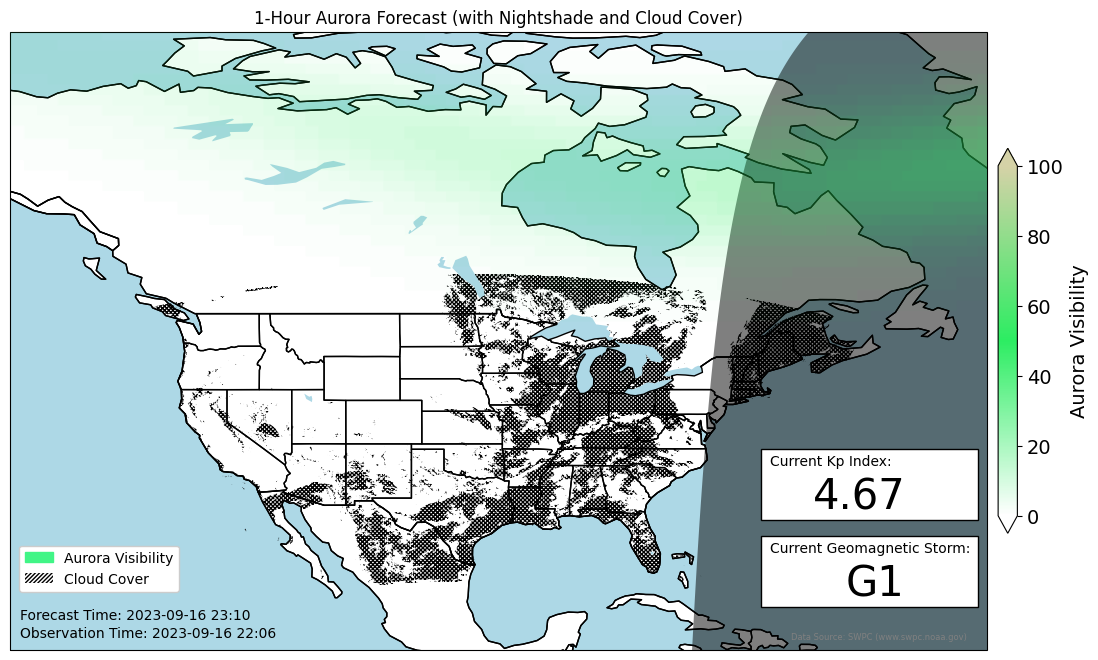

In [10]:
import cartopy.feature as cfeature

fig = plt.figure(figsize=[15, 10])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# add a night shade
ax.add_feature(Nightshade(dt), zorder = 12)

# plot Aurora data
c = ax.imshow(img, vmin=0, vmax=100, transform=crs,
                  extent=extent, origin=origin, zorder=13,
                  cmap=aurora_cmap())

# add land and sea features
s = cfeature.AdaptiveScaler('110m',(('50m', 50), ('10m', 10)))
PL = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale=s, facecolor='none')
ax.add_feature(PL, edgecolor='black',  facecolor='none')
ax.add_feature(cartopy.feature.STATES, facecolor='none', edgecolor='black', zorder = 9)
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')

# plot the cloud data
ax.contourf(ds.lon.values, ds.lat.values, (cloud * mask) > 50, transform=ccrs.PlateCarree(), colors='none', levels=[.5, 1.5], hatches=[8*'\/',8*'\/'])

# Create title and annotation
ax.set_title(f'1-Hour Aurora Forecast (with Nightshade and Cloud Cover)')

ax.annotate(f'Forecast Time: {dt.strftime("%Y-%m-%d %H:%M")}', (0.01, 0.05), xycoords='axes fraction')
ax.annotate(f'Observation Time: {dt2.strftime("%Y-%m-%d %H:%M")}', (0.01, 0.02), xycoords='axes fraction')

# Create Custom Colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, 101, 20)), ax=ax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='Aurora Visibility', size=14)

# Create custom legend
aurora_patch = mpatches.Patch(color='#40F586', label='Aurora Visibility')
cloud_patch = mpatches.Patch(facecolor='#FFFFFF',alpha=0.6, label='Cloud Cover', hatch=r'////////')
ax.legend(handles=[aurora_patch, cloud_patch], bbox_to_anchor=(0.18, 0.18), framealpha=1, facecolor='white').set_zorder(14)

# Set extent of image
ax.set_extent([220, 310, 18, 75], crs=ccrs.PlateCarree())

# Create annotations for the current geomagnetic storm and Kp index
ax.text(-70, 27, 'Current Geomagnetic Storm:', fontsize=10).set_zorder(14)
ax.text(-63, 23, gstorm, fontsize=30).set_zorder(14)
patch_1 = mpatches.Rectangle((-70.75, 22), 20, 6.5, edgecolor='k', facecolor='white', zorder=13)
ax.add_patch(patch_1)

ax.text(-70, 35, 'Current Kp Index:', fontsize=10).set_zorder(14)
ax.text(-66, 31, Kp, fontsize=30).set_zorder(14)
patch_2 = mpatches.Rectangle((-70.75, 30), 20, 6.5, edgecolor='k', facecolor='white', zorder=13)
ax.add_patch(patch_2)

ax.text(-68, 19, 'Data Source: SWPC (www.swpc.noaa.gov)', fontsize=6, color = 'grey').set_zorder(14)

## Original Script For Aurora

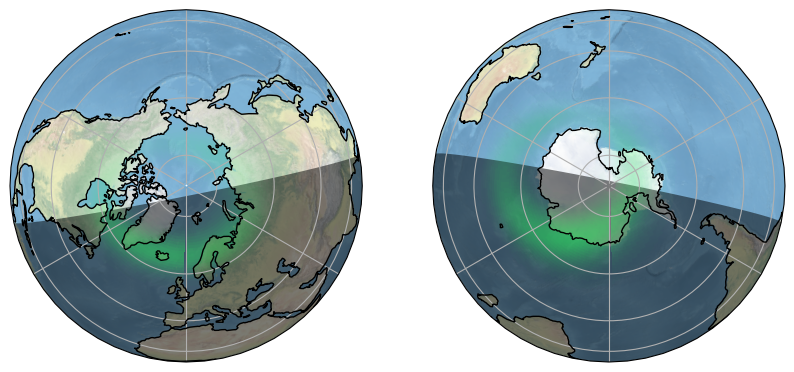

In [11]:
############# OG Script ####################
def aurora_forecast():
    """
    Get the latest Aurora Forecast from https://www.swpc.noaa.gov.

    Returns
    -------
    img : numpy array
        The pixels of the image in a numpy array.
    img_proj : cartopy CRS
        The rectangular coordinate system of the image.
    img_extent : tuple of floats
        The extent of the image ``(x0, y0, x1, y1)`` referenced in
        the ``img_proj`` coordinate system.
    origin : str
        The origin of the image to be passed through to matplotlib's imshow.
    dt : datetime
        Time of forecast validity.

    """

    # GitHub gist to download the example data from
    #url = ('https://gist.githubusercontent.com/lgolston/594c030876c0614d3'
     #      '6d13d03e4f115b6/raw/342ff751419204594180e88d69b3986dbd4fea4a/'
      #     'ovation_aurora_latest.json')
    # To plot the current forecast instead, uncomment the following line
    url = 'https://services.swpc.noaa.gov/json/ovation_aurora_latest.json'

    # load data (JSON format)
    response = urlopen(url)
    aurora = json.loads(response.read().decode('utf-8'))
    # parse timestamp
    dt = datetime.strptime(aurora['Forecast Time'], '%Y-%m-%dT%H:%M:%SZ')
    # convert lists of [lon, lat, value] to 2D array of probability values
    aurora_data = np.array(aurora['coordinates'])
    img = np.reshape(aurora_data[:, 2], (181, 360), order='F')

    img_proj = ccrs.PlateCarree()
    img_extent = (0, 359, -90, 90)
    return img, img_proj, img_extent, 'lower', dt


def aurora_cmap():
    """Return a colormap with aurora like colors"""
    stops = {'red': [(0.00, 0.1725, 0.1725),
                     (0.50, 0.1725, 0.1725),
                     (1.00, 0.8353, 0.8353)],

             'green': [(0.00, 0.9294, 0.9294),
                       (0.50, 0.9294, 0.9294),
                       (1.00, 0.8235, 0.8235)],

             'blue': [(0.00, 0.3843, 0.3843),
                      (0.50, 0.3843, 0.3843),
                      (1.00, 0.6549, 0.6549)],

             'alpha': [(0.00, 0.0, 0.0),
                       (0.50, 1.0, 1.0),
                       (1.00, 1.0, 1.0)]}

    return LinearSegmentedColormap('aurora', stops)


def main():
    fig = plt.figure(figsize=[10, 5])

    # We choose to plot in an Orthographic projection as it looks natural
    # and the distortion is relatively small around the poles where
    # the aurora is most likely.

    # ax1 for Northern Hemisphere
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

    # ax2 for Southern Hemisphere
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))

    img, crs, extent, origin, dt = aurora_forecast()

    for ax in [ax1, ax2]:
        ax.coastlines(zorder=3)
        ax.stock_img()
        ax.gridlines()
        ax.add_feature(Nightshade(dt))
        ax.imshow(img, vmin=0, vmax=100, transform=crs,
                  extent=extent, origin=origin, zorder=2,
                  cmap=aurora_cmap())

    plt.show()


if __name__ == '__main__':
    main()